# 📚 Exercise Session - Week 3: Attention + Transformers
**Main Topics**: Attention & Transformers for Sequence-to-Sequence Modeling

**Overview**

This week’s session dives into Transformers for sequence-to-sequence (Seq2Seq) tasks, with a special focus on machine translation and attention visualization. By the end, you will have built and trained a Transformer model capable of translating text from one language to another—and you’ll see how attention helps it learn alignments across tokens.

1. [**TASK A:** Transformer Implementation](#Task-A:-Transformer-Implementation)
- Build a BPE tokenizer
- Implement a Transformer encoder-decoder model using PyTorch

2. [**TASK B:** Train a Machine Translation Model](#Task-B:-Train-a-Machine-Translation-Model)
- Use Transformer from Task A to train a machine translation model
- Visualize the cross-attention weights

3. **Optional Extensions** 
- Learning Rate Scheduler: Try adding a scheduler (like Warmup or ReduceLROnPlateau) to potentially improve convergence.
- Periodic Validation: Every `m` batches or at epoch’s end, evaluate on a validation set to track loss or metrics like BLEU.
- Use PyTorch `DataLoader`

**Tips & Hints**
- **Overfitting on a Single Example**: If your model cannot easily learn one sample to near-perfect accuracy, it often indicates an implementation bug or mismatch in shapes/masks.
- **Masking**: Pay careful attention to causal masks in the decoder, ensuring the model does not see future tokens.
- **Debugging**: Print shapes and partial outputs, or watch the attention scores to confirm they behave as expected.


> **By the end of the session you will be able to:**
> - ✅  Implement an encoder-decoder Transformer model using PyTorch
> - ✅  Train your model on a machine translation corpus
> - ✅  Understand attention mechanism within the Transformer architecture
> - ✅  Be more interested in NLP 😉

## Task A: Transformer Implementation

**Quick Reminder**
We will be implementing the following encoder-decoder transformer architecture following the original [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper!

![Transformer Architecture](transformer_arch.png)

In this part, you will implement an encoder-decoder Transformer model using [Pytorch](https://pytorch.org/)

In [19]:
!pip install datasets
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Transformer Architecture

In [20]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# For reproducibility
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [39]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # These layers transform the input embeddings to queries, keys, and values
        self.query_proj = nn.Linear(embed_dim, embed_dim)
        self.key_proj   = nn.Linear(embed_dim, embed_dim)
        self.value_proj = nn.Linear(embed_dim, embed_dim)

        # Final projection after concatenating heads
        self.out_proj   = nn.Linear(embed_dim, embed_dim)

        # Dropout for attention weights
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: [batch_size, seq_len, embed_dim]
        mask: [batch_size, 1, seq_len, seq_len] or None (optional)

        returns:
          - output: [batch_size, seq_len, embed_dim]
          - attn_weights: [batch_size, num_heads, seq_len, seq_len]
        """
        batch_size = query.size(0)
        
        # 1) Linear projections
        # TODO: project query, key, and value via the layers: self.query_proj, self.key_proj, self.value_proj
        # shape after projection: [batch_size, seq_len, embed_dim]
        Q = self.query_proj(query)
        K = self.key_proj(key)
        V = self.value_proj(value)

        # 2) Split into multiple heads
        # We want shape: [batch_size, num_heads, seq_len, head_dim]
        # TODO: reshape the Q, K, V so that we chunk embed_dim into (num_heads, head_dim)
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1,2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1,2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1,2)

        # 3) Scaled dot-product attention
        #    attention_scores = Q x K^T / sqrt(head_dim)
        #    then apply optional mask (if not None)
        #    then softmax, then dropout, then multiply by V

        # TODO: compute attention_scores
        # attention_scores shape: [batch_size, num_heads, seq_len, seq_len]
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        # TODO: apply mask if given
        if mask is not None:
          attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        # TODO: normalize attention_scores
        
        
        # TODO: compute attention_output
        # shape: [batch_size, num_heads, seq_len, head_dim]

        attn_weights = F.softmax(attention_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        attention_output = torch.matmul(attn_weights, V)

        # 4) Concat heads
        # We want shape: [batch_size, seq_len, embed_dim]
        # (i.e. combine num_heads and head_dim back into embed_dim)
        attention_output = attention_output.transpose(1, 2).contiguous()
        attention_output = attention_output.view(batch_size, -1, self.embed_dim)
        
        # 5) Final linear projection
        output = self.out_proj(attention_output)

        
        return output, attn_weights  # (attn_weights = normalized_weights for visualization)

In [22]:
class EncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout=0):
        super(EncoderLayer, self).__init__()

        self.self_attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.linear1   = nn.Linear(embed_dim, hidden_dim)
        self.linear2   = nn.Linear(hidden_dim, embed_dim)
        self.norm1     = nn.LayerNorm(embed_dim)
        self.norm2     = nn.LayerNorm(embed_dim)
        self.dropout1  = nn.Dropout(dropout)
        self.dropout2  = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # x shape: [batch_size, seq_len, embed_dim]
        
        # 1) Multi-head self-attention
        attn_output, _ = self.self_attn(x, x, x, mask=mask)
        x = x + attn_output  # residual
        x = self.norm1(x)

        # 2) Feed-forward
        ff_output = self.linear2(F.relu(self.linear1(x)))
        x = x + ff_output  # residual
        x = self.norm2(x)

        return x

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout=0):
        super(DecoderLayer, self).__init__()

        # Multi-Head Attention Layers
        self.self_attn = MultiHeadAttention(embed_dim, num_heads, dropout)   # Students already have MHA
        self.cross_attn = MultiHeadAttention(embed_dim, num_heads, dropout)

        # Feed-Forward Layers
        self.linear1 = nn.Linear(embed_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, embed_dim)

        # LayerNorms
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)


    def forward(self, x, enc_output, tgt_mask=None, cross_attn_mask=None):
        """
        Args:
            x: [batch_size, tgt_seq_len, embed_dim] -- decoder input embeddings
            enc_output: [batch_size, src_seq_len, embed_dim] -- encoder output
            tgt_mask: mask for target self-attention (e.g., causal + padding)
            cross_attn_mask: mask for encoder-decoder attention (padding mask for source)
        Returns:
            x: [batch_size, tgt_seq_len, embed_dim] -- updated decoder features
            attn_weights: attention weights from cross-attention (for visualization, etc.)
        """

        attn_output, _ = self.self_attn(x, x, x, mask=tgt_mask)
        x = x + attn_output
        x = self.norm1(x)

        # 1) TODO: Implement cross-attention with encoder output
        #    - Query = x (decoder), Key/Value = enc_output
        #    - residual connection + self.norm2
        
        cross_attn_output, attn_weights = self.cross_attn(x, enc_output, enc_output, mask=cross_attn_mask)
        x = x + cross_attn_output
        x = self.norm2(x)

        # 2) TODO: Implement feed-forward sub-layer
        #    - pass x through self.linear1, then an activation (e.g., F.relu)
        #    - then self.linear2
        #    - Add residual + self.norm3
        ff_output = self.linear2(F.relu(self.linear1(x)))
        x = x + ff_output
        x = self.norm3(x)

        # TODO: return final x and the cross-attention weights
        return x, attn_weights


In [24]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, max_len=1024, dropout=0):
        super(Encoder, self).__init__()
        self.embed_dim = embed_dim
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = nn.Embedding(max_len, embed_dim)
        self.layers = nn.ModuleList([
            EncoderLayer(embed_dim, num_heads, hidden_dim, dropout) for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        """
        src: [batch_size, src_seq_len]
        src_mask: (optional)
        """
        x = self.embedding(src) * math.sqrt(self.embed_dim)

        # TODO: Add positional encoding to the input embeddings
        x = x + self.pos_encoding(torch.arange(src.size(1)).to(src.device)).unsqueeze(0)

        

        # TODO: Implement the forward pass through the encoder layers
        for layer in self.layers:
            x = layer(x, mask=src_mask)
        
        return x  # shape: [batch_size, src_seq_len, embed_dim]


class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, max_len=1024, dropout=0):
        super(Decoder, self).__init__()
        self.embed_dim = embed_dim

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = nn.Embedding(max_len, embed_dim)
        self.layers = nn.ModuleList([
            DecoderLayer(embed_dim, num_heads, hidden_dim, dropout) for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(embed_dim, vocab_size)

    def forward(self, tgt, enc_output, tgt_mask=None, cross_attn_mask=None):
        """
        tgt: [batch_size, tgt_seq_len]
        enc_output: [batch_size, src_seq_len, embed_dim]
        """
        x = self.embedding(tgt) * math.sqrt(self.embed_dim)
        # TODO: Add positional encoding to the input embeddings
        x = x + self.pos_encoding(torch.arange(tgt.size(1)).to(tgt.device)).unsqueeze(0)


        attn_weights = None
        for layer in self.layers:
            x, attn_weights = layer(x, enc_output, tgt_mask=tgt_mask, cross_attn_mask=cross_attn_mask)

        # Final projection to vocabulary
        logits = self.out_proj(x)  # [batch_size, tgt_seq_len, vocab_size]
        return logits, attn_weights

In [25]:
import torch

def build_causal_mask(seq_len, device=None):
    """
    Returns a 2D causal mask of shape [seq_len, seq_len], 
    where True means 'allowed to attend' and False means 'disallowed'.
    """
    return torch.tril(torch.ones((seq_len, seq_len), dtype=torch.bool, device=device))

def expand_causal_mask(causal_2d, batch_size, num_heads):
    # causal_2d: shape [seq_len, seq_len]
    # expand to [batch_size, num_heads, seq_len, seq_len]
    causal_4d = causal_2d.unsqueeze(0).unsqueeze(0)  # => [1,1,seq_len,seq_len]
    causal_4d = causal_4d.expand(batch_size, num_heads, causal_2d.size(0), causal_2d.size(1))
    return causal_4d

def expand_padding_mask(pad_mask_2d, num_heads):
    # pad_mask_2d: shape [batch_size, seq_len], 1 = valid, 0 = pad
    # step 1) Convert to bool if needed
    pad_mask_bool = pad_mask_2d.bool()  # shape [batch_size, seq_len]
    # step 2) unsqueeze => [batch_size, 1, 1, seq_len]
    pad_mask_4d = pad_mask_bool.unsqueeze(1).unsqueeze(2)
    # step 3) broadcast across the query dimension
    batch_size, _, _, seq_len = pad_mask_4d.shape
    pad_mask_4d = pad_mask_4d.expand(batch_size, num_heads, seq_len, seq_len)
    return pad_mask_4d


def build_decoder_mask(
    pad_mask_2d: torch.Tensor, 
    num_heads: int
):
    """
    Combine the target padding mask with the causal mask 
    to produce a final decoder mask of shape:
    [batch_size, num_heads, seq_len, seq_len], 
    where True means 'allowed', False means 'masked out'.
    """
    device = pad_mask_2d.device
    batch_size, seq_len = pad_mask_2d.shape

    # 1) Build the 2D causal mask
    causal_2d = build_causal_mask(seq_len, device=device)

    # 2) Expand to 4D
    causal_4d = expand_causal_mask(causal_2d, batch_size, num_heads)

    # 3) Expand the padding mask to 4D
    pad_4d = expand_padding_mask(pad_mask_2d, num_heads)

    # 4) Final mask = causal AND pad
    final_mask = causal_4d & pad_4d  # shape [batch_size, num_heads, seq_len, seq_len]
    return final_mask


In [26]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_dim=512, num_heads=8, hidden_dim=2048, 
                 num_layers=6, dropout=0):
        super(Transformer, self).__init__()
        self.num_heads = num_heads
        self.encoder = Encoder(src_vocab_size, embed_dim, num_heads, hidden_dim, num_layers, dropout=dropout)
        self.decoder = Decoder(tgt_vocab_size, embed_dim, num_heads, hidden_dim, num_layers, dropout=dropout)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, cross_attn_mask=None):

        if src_mask is not None:
            src_mask = src_mask[:, None, None, :]
            src_mask = src_mask.expand(-1, -1, src_mask.size(-1), -1)

        tgt_mask = build_decoder_mask(tgt_mask, num_heads=self.num_heads)

        enc_output = self.encoder(src, src_mask)
        logits, attn_weights = self.decoder(tgt, enc_output, tgt_mask, cross_attn_mask)
        return logits, attn_weights

## Task B: Train a Machine Translation Model

First, you need to download the French-English translation dataset using [this link](https://drive.google.com/file/d/1cPKNjpU7PiqA33GzV0yICwDjZ_0ysKjO/view?usp=sharing)

In [27]:
import torch
import numpy as np
from datasets import load_from_disk

# Load the dataset
dataset = load_from_disk("wmt14_fr_en")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 100000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 3003
    })
})


### Build a BPE Tokenizer

> You will learn about BPE tokenization later in the semester. Here we provide you with the code necessary to train your own tokenizer.

In [28]:
from tokenizers import ByteLevelBPETokenizer

def batch_iterator(dataset, batch_size=1000):
    """
    Yields batches of text from the Hugging Face dataset.
    Args:
        dataset: a huggingface dataset split (e.g. train_dataset)
        batch_size: how many samples per batch
        text_column: name of the column containing the text
    """
    for i in range(0, len(dataset), batch_size):
        # Extract a batch of examples
        batch = dataset[i : i + batch_size]

        # 'batch' is now a list of strings (if text_column is indeed text).
        yield batch


fr_training_set = [dataset["train"][i]['translation']['fr'] for i in range(100_000)]
en_training_set = [dataset["train"][i]['translation']['en'] for i in range(100_000)]
training_set = en_training_set + fr_training_set

# 1) Initialize tokenizer
tokenizer = ByteLevelBPETokenizer()

# 2) Train from the iterator
tokenizer.train_from_iterator(
    iterator=batch_iterator(training_set, batch_size=1000),
    vocab_size=32_000,  # Choose your vocab size
    min_frequency=2,
    special_tokens=["<pad>", "<unk>", "<s>", "</s>"]  # Or any set of special tokens you prefer
)

# 3) Save the tokenizer
tokenizer.save("my_bytelevel_tokenizer.json")

In [29]:
# Load the tokenizer
from transformers import PreTrainedTokenizerFast

hf_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file="my_bytelevel_tokenizer.json",  # or the two files from the BPE approach
    bos_token="<s>",
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>"
)

encoded_input = hf_tokenizer("The quick brown fox", return_tensors="pt", add_special_tokens=True)
decoded_output = hf_tokenizer.convert_ids_to_tokens(encoded_input["input_ids"][0])

print(encoded_input)
print(decoded_output)

{'input_ids': tensor([[ 439, 8722, 6667, 1727,  291, 3255]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}
['The', 'Ġquick', 'Ġbro', 'wn', 'Ġf', 'ox']


### Define Hyperparameters

In [30]:
# Training parameters
epochs = 1
batch_size = 16
max_len = 256
learning_rate = 1e-4

# Model parameters
embed_dim = 512
num_heads = 8
hidden_dim = 2048
num_layers = 4

### Training Loop

In [40]:
print("Initializing the Transformer model...")
model = Transformer(
    src_vocab_size=hf_tokenizer.vocab_size, 
    tgt_vocab_size=hf_tokenizer.vocab_size,
    num_layers=num_layers,
    embed_dim=embed_dim,
    num_heads=num_heads,
    hidden_dim=hidden_dim
)
model.to(device)

# Print the number of parameters
print(f"> Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

# Compute total number of batches in the training set
num_batches = int(np.ceil(len(dataset['train']) / batch_size))

# Define Loss and Optimizer
loss_fn = nn.CrossEntropyLoss(ignore_index=hf_tokenizer.pad_token_id)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

train_losses = []

# Switch model to training mode
model.train()
for epoch_num in range(epochs):
    
    for batch_idx in range(num_batches):
        train_batch = dataset['train'][batch_idx * batch_size : (batch_idx + 1) * batch_size]['translation']

        src_train = [example['fr'] for example in train_batch]
        tgt_train = [example['en'] for example in train_batch]
        
        src_tokens = hf_tokenizer(
            src_train, 
            return_tensors='pt', 
            padding=True, 
            truncation=True, 
            max_length=max_len
        ).to(device)

        tgt_tokens = hf_tokenizer(
            tgt_train, 
            return_tensors='pt', 
            padding=True, 
            truncation=True, 
            max_length=max_len
        ).to(device)

        # 1) TODO: Prepend BOS token to target tokens
        tgt_tokens["input_ids"] = torch.cat([
            torch.full_like(tgt_tokens["input_ids"][:, :1], hf_tokenizer.bos_token_id), 
            tgt_tokens["input_ids"][:, :-1]
        ], dim=1)
 
        # 2) TODO: Forward pass through the Transformer
        logits, _ = model(
            src=src_tokens['input_ids'],
            tgt=tgt_tokens["input_ids"],
            src_mask=src_tokens["attention_mask"],
            tgt_mask=tgt_tokens["attention_mask"],
        )

        # 3) TODO: Shift labels to the right (teacher forcing)
        labels = tgt_tokens["input_ids"][:, 1:].contiguous()
        logits = logits[:, :-1].contiguous()
        
        # 4) TODO: Compute loss
        optimizer.zero_grad()
        loss = loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))

        # 5) TODO: Backpropagate and update weights
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        print(f"Epoch {epoch_num}, Batch {batch_idx}/{num_batches}, Loss: {loss.item():.4f}", end='\r')

    print(f"Epoch {epoch_num} Finished! Avg Loss: {np.mean(train_losses):.4f}")


print("Saving model checkpoint...")
torch.save(model.state_dict(), "transformer_model.pt")
print("Training complete!")

Initializing the Transformer model...
> Number of parameters: 79,658,240
Epoch 0 Finished! Avg Loss: 5.94090795
Saving model checkpoint...
Training complete!


### Plot Training Loss Curve

Text(0.5, 1.0, 'Training Loss')

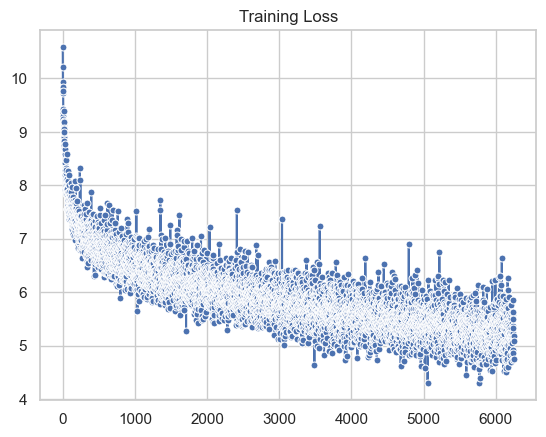

In [41]:
# Plot loss
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
sns.lineplot(x=range(len(train_losses)), y=train_losses, marker='o', markersize=5)
plt.title("Training Loss")

### Generate Some Examples

Generate using greedy decoding. You will learn more about it in class later in the semester.

Here is a [link for a checkpoint](https://drive.google.com/file/d/130dDwMBJGhvSEFQdHkxaU-R5IjlSbO2j/view?usp=sharing) that you can use for prediction and attention weight visualization.
It was trained using the following configuration
```
embed_dim = 512
num_heads = 8
hidden_dim = 2048
num_layers = 4
vocab_size = 32000
```

In [42]:
# Load the model
model = Transformer(
    src_vocab_size=hf_tokenizer.vocab_size, 
    tgt_vocab_size=hf_tokenizer.vocab_size,
    num_layers=num_layers,
    embed_dim=embed_dim,
    num_heads=num_heads,
    hidden_dim=hidden_dim
)
model.to(device)

state_dict = torch.load("transformer_model.pt")
model.load_state_dict(state_dict)

src_val = [dataset['train'][i]['translation']['fr'] for i in range(5)]
tgt_val = [dataset['train'][i]['translation']['en'] for i in range(5)]

src_tokens_val = hf_tokenizer(src_val, return_tensors='pt', padding=True, truncation=True, max_length=max_len).to(device)

model.eval()
with torch.no_grad():
    for i in range(5):
        # Prepare inputs
        src = src_tokens_val['input_ids'][i].unsqueeze(0).to(device)
        tgt = torch.tensor([[hf_tokenizer.bos_token_id]], dtype=torch.long, device=device)

        # Greedy decode up to max_len
        for step in range(max_len):
            # Create tgt padding mask
            tgt_mask = torch.ones_like(tgt).bool().to(device)

            # Forward pass
            logits, _ = model(src, tgt, tgt_mask=tgt_mask)

            # Get the most probable token at the current step
            next_token = logits[:, -1, :].argmax(dim=-1)

            # Append
            tgt = torch.cat([tgt, next_token.unsqueeze(-1)], dim=1)

            # End conditions
            if next_token.item() in [hf_tokenizer.eos_token_id, hf_tokenizer.pad_token_id]:
                break

        # Decode
        translation = hf_tokenizer.decode(tgt[0], skip_special_tokens=True)

        print(f"Example {i+1}:")
        print(f"  Source:      {src_val[i]}")
        print(f"  Translation: {translation}")
        print(f"  Target:      {tgt_val[i]}\n")

Example 1:
  Source:      À mesure que Maurice devient une économie à forte intensité de savoir, que le secteur des technologies de l'information et de la communication (TIC) se développe avec l'idée de faire de Maurice une cyber-île, l'écart actuel des connaissances risque fort de se creuser, surtout chez les femmes, sauf si les réformes de l'enseignement sont adaptées aux impératifs neufs du marché du travail.
  Translation: As a result of the work of the work of the work of the work of the work of the work of the work of the work of the work of the work of the work of the work of the work of the work of the work of the work of the use of the work of the work of the work of the work of the work of the work of the use. The work is to be used in the use of the work of the work of the work of the work of the work of the work of the work of the work of the work of the use of the work of the work of the work of the work of the work of the use of the work of the work of the use of the use 

## Analyze Cross-Attention Weights

- Choose one sample sentence, output attention weights for each token using heatmap
- Which pairs of the token have the greatest attention weight?

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_cross_attention(
    attn_weights, 
    source_tokens, 
    target_tokens, 
    batch_idx=0, 
    head_idx=0, 
    title="Cross-Attention"
):
    """
    Visualize cross-attention weights for a given batch and head.

    Args:
        attn_weights: Tensor of shape [batch_size, num_heads, tgt_len, src_len]
            Cross-attention weights from your Transformer decoder, 
            typically returned alongside logits in a (logits, attn_weights) tuple.
        source_tokens: List of source tokens (strings) for the batch_idx sample.
        target_tokens: List of target tokens (strings) for the batch_idx sample.
        batch_idx: Which batch element to visualize (default=0).
        head_idx: Which attention head to visualize (default=0).
        title: Title for the plot.

    Example Usage:
        # Suppose attn_weights has shape [batch_size, num_heads, tgt_len, src_len]
        # and you have the corresponding token lists for the source and target:
        visualize_cross_attention(attn_weights, src_tokens, tgt_tokens)
    """

    # 1) Extract the attention for the specified batch & head
    #    shape: [tgt_len, src_len]
    attn = attn_weights[batch_idx, head_idx].detach().cpu().numpy()

    tgt_len, src_len = attn.shape

    # 2) Plot the heatmap
    plt.figure(figsize=(min(12, 1 + 0.5 * src_len), min(6, 1 + 0.5 * tgt_len)))
    sns.heatmap(attn, 
                vmin=0.0, vmax=1.0, 
                cmap="Blues", 
                xticklabels=source_tokens, 
                yticklabels=target_tokens, 
                cbar=True)

    plt.title(f"{title} (batch={batch_idx}, head={head_idx})")
    plt.xlabel("Source Tokens")
    plt.ylabel("Target Tokens")

    # Rotate the x-axis labels if tokens are long
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


torch.Size([1, 18])
torch.Size([1, 14])


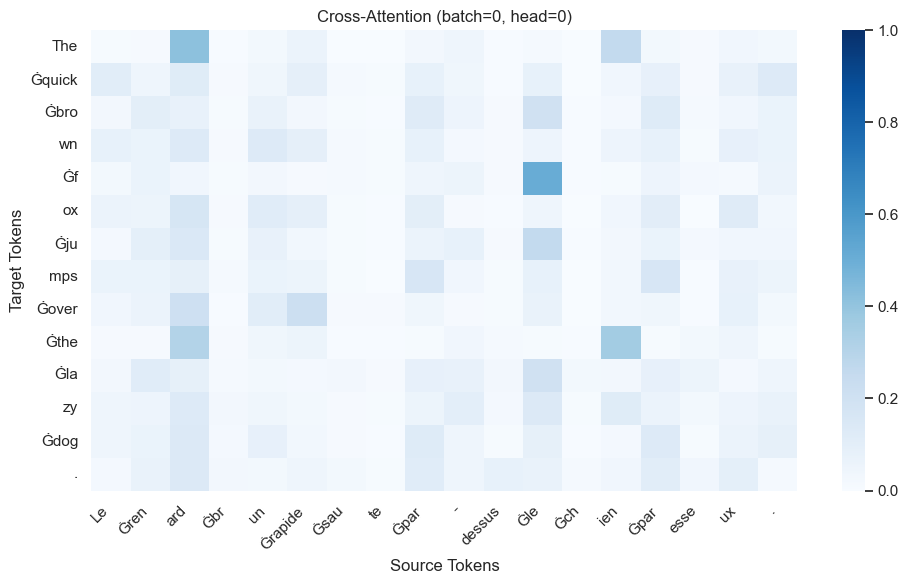

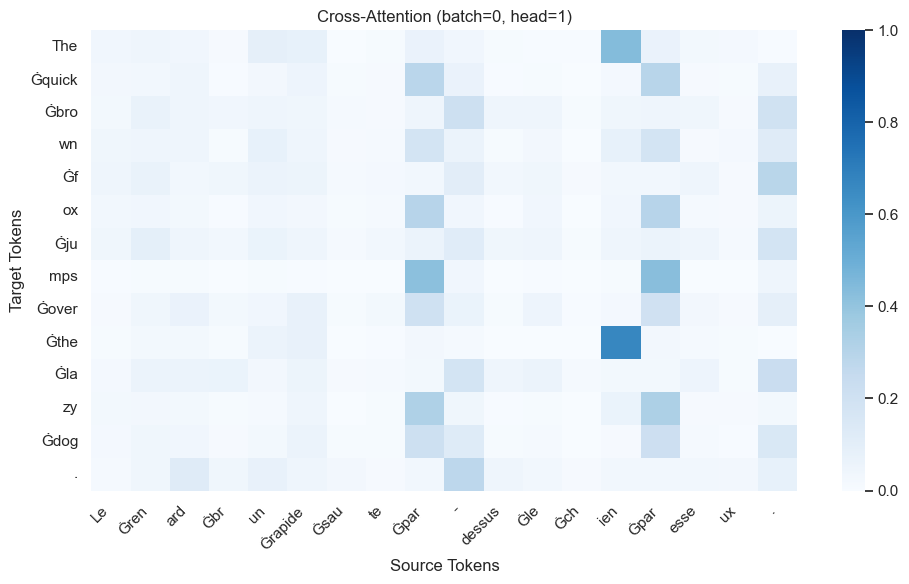

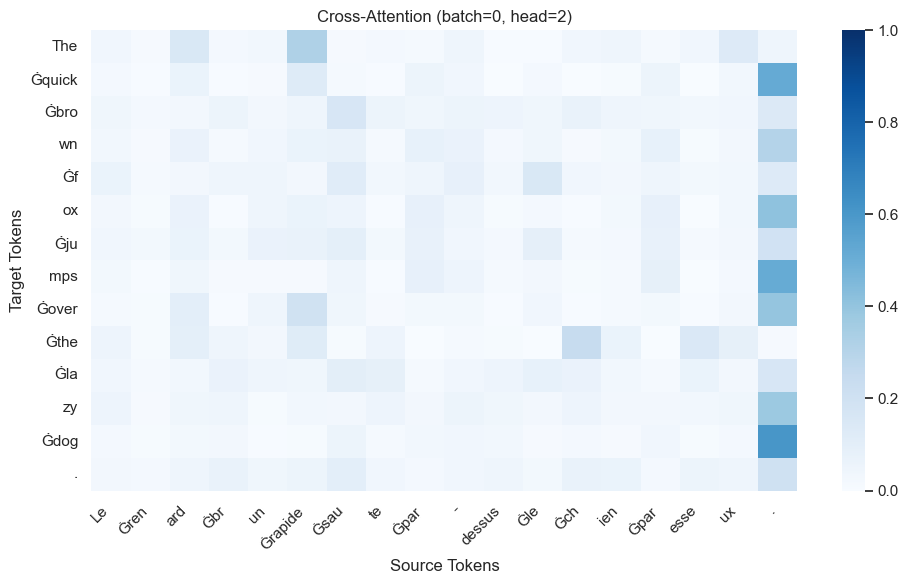

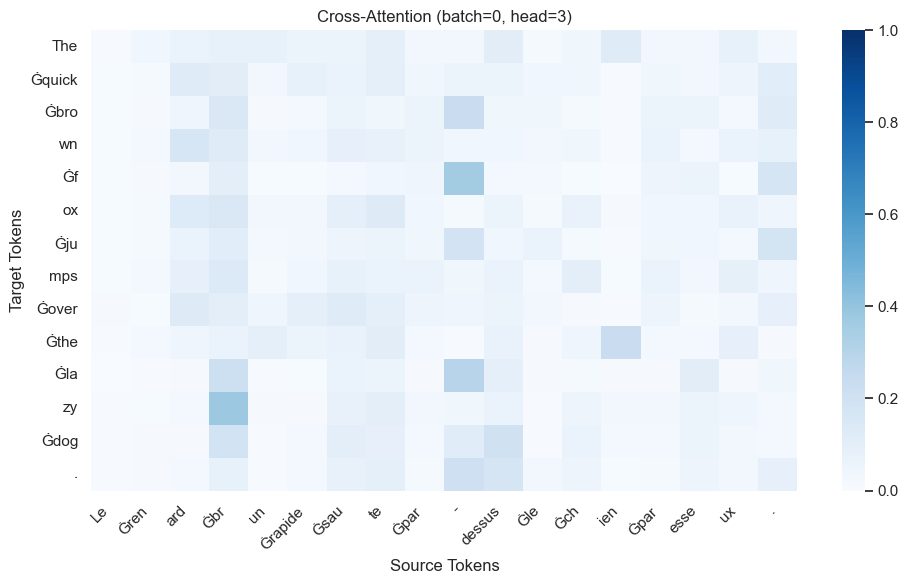

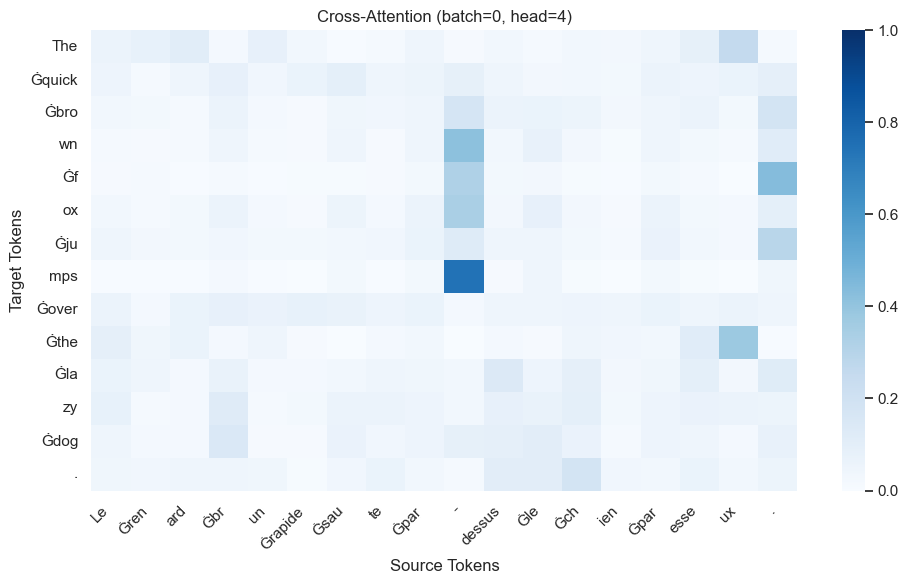

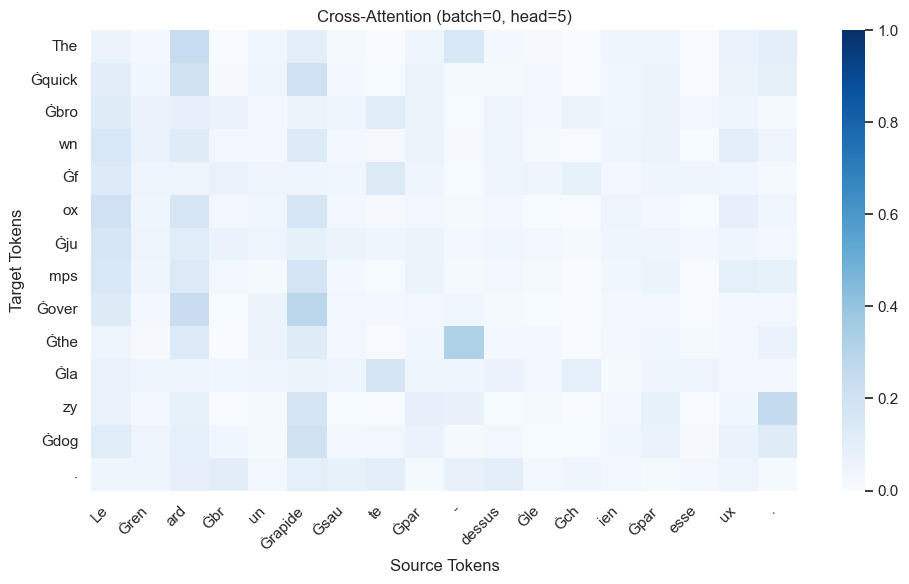

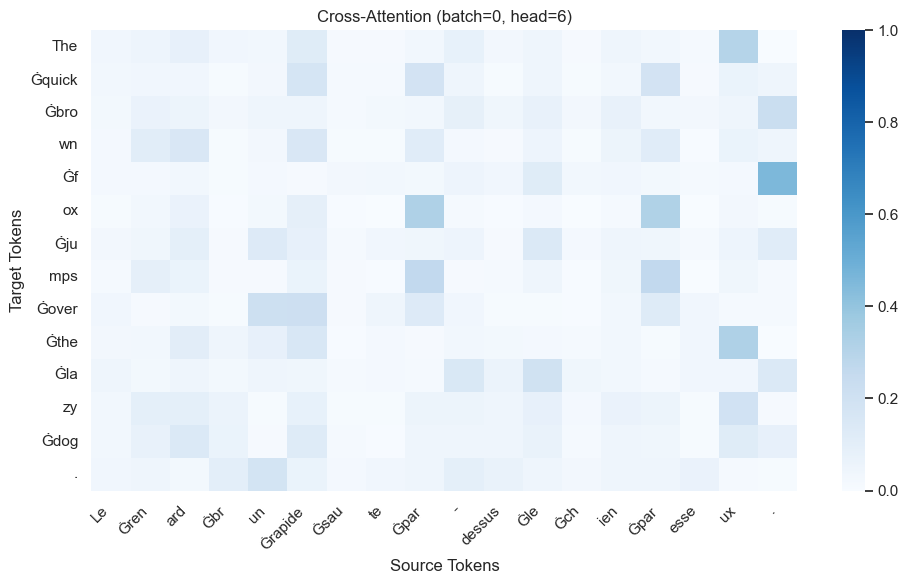

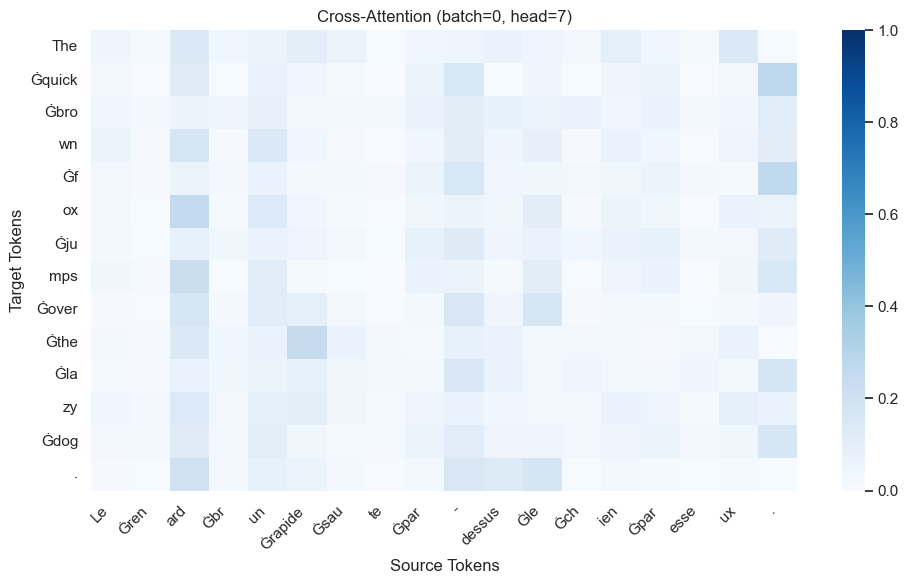

In [44]:
src_val = "Le renard brun rapide saute par-dessus le chien paresseux."
tgt_val = "The quick brown fox jumps over the lazy dog."

# Tokenize the source and target
src_tokens_val = hf_tokenizer(src_val, return_tensors='pt', padding=True, truncation=True, max_length=max_len).to(device)
tgt_tokens_val = hf_tokenizer(tgt_val, return_tensors='pt', padding=True, truncation=True, max_length=max_len).to(device)

print(src_tokens_val["input_ids"].shape)
print(tgt_tokens_val["input_ids"].shape)

# Run the model
model.eval()
with torch.no_grad():
    logits, attn_weights = model(
        src=src_tokens_val['input_ids'],
        tgt=tgt_tokens_val['input_ids'],
        src_mask=src_tokens_val['attention_mask'],
        tgt_mask=tgt_tokens_val['attention_mask']
    )

# Decode the source and target sequences
src_tokens = hf_tokenizer.convert_ids_to_tokens(src_tokens_val["input_ids"][0])
tgt_tokens = hf_tokenizer.convert_ids_to_tokens(tgt_tokens_val["input_ids"][0])

# Visualize the attention weights
for i in range(num_heads):
    visualize_cross_attention(
        attn_weights=attn_weights,
        source_tokens=src_tokens,
        target_tokens=tgt_tokens,
        batch_idx=0,
        head_idx=i
    )

## Congrats! You can now train a simple machine translator by your own ;)